# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from utils import *

#### Hyperparameters

In [2]:
# threshold values for cut-in speeds of German and French wind turbines, respectively.
de_wind_switch = 1.5
fr_wind_switch = 1.5

In [3]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

<Axes: xlabel='ID', ylabel='FR_COAL'>

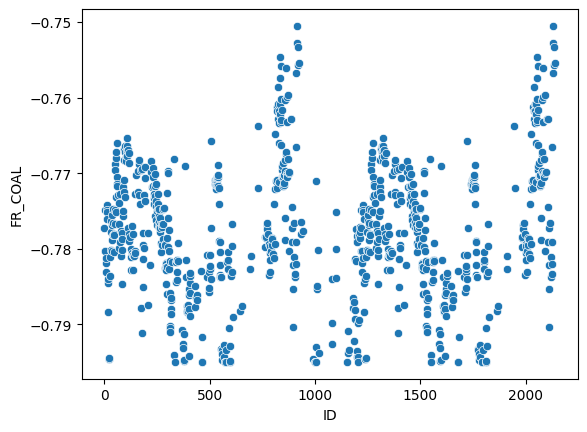

In [4]:
sns.scatterplot(x=df[df['FR_COAL'] < -0.75].index, y=df[df['FR_COAL'] < -0.75]['FR_COAL'])

In [5]:
df[df['COUNTRY'] == 'DE'].sort_index()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1190,DE,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
2,38,DE,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
3,872,DE,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
4,933,DE,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
5,750,DE,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,-0.746381,-0.780286,-0.014076,-0.507558,0.131863,0.297371,1.377499,0.117900,0.639742,-0.407567,0.247893,-0.613143,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,701,DE,1.032122,0.383270,0.451691,-0.451691,0.437667,-1.106814,-0.437667,1.106814,0.533996,1.097201,0.568480,-0.216372,-0.473725,-0.883788,-1.914119,-1.489547,-1.120453,-0.213344,1.023247,3.298833,0.347272,0.163624,-0.322860,-0.042241,0.517631,1.506315,2.584335,-1.225979,-0.113555,0.785530,-0.322581,0.362803
927,112,DE,0.979093,0.338229,1.138619,-1.138619,0.480707,-1.631364,-0.480707,1.631364,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.086420,0.643169,1.007158,1.445712,-0.107380,-0.046727,0.961630,0.891689,1.012246
928,102,DE,1.009837,0.237311,-0.093751,0.093751,-0.425785,-1.194162,0.425785,1.194162,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,0.213069,-0.442086,0.601170,1.439691,0.047149,0.364089,-0.784590,1.046452,-0.545607


In [6]:
true_test[true_test['COUNTRY'] == 'DE'].sort_index().head(30)

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1072,DE,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,0.959734,-0.144798,-0.096841,-0.428909,-0.602358,-0.771224,0.804110,0.510648,0.500201,0.284886,0.066511,0.124200,0.790924,0.200128,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340
6,472,DE,0.448365,0.057480,-0.378787,0.378787,0.972761,0.728716,-0.972761,-0.728716,0.787415,0.561132,-0.622520,-0.781431,-0.295697,-0.541968,0.109288,0.241592,1.112920,0.827929,0.494851,-0.134960,0.260600,-0.471106,0.038227,-0.281556,-0.273116,-0.328795,-0.543968,0.250721,-0.489679,1.393826,0.542969,0.844307
7,447,DE,0.094138,-0.196407,-0.526749,0.526749,1.064523,0.867473,-1.064523,-0.867473,-0.028746,-0.191087,-1.016151,-0.770888,-0.538727,-0.725952,0.019590,0.209744,1.554578,0.843117,0.855318,0.350950,-0.539181,-1.164182,-0.324601,-0.357140,-0.173932,-0.353357,-0.517815,0.708057,0.739899,-1.472538,-0.659916,-1.668585
11,411,DE,0.176210,-0.205967,-1.192766,1.192766,-1.878711,1.012265,1.878711,-1.012265,0.220693,-0.719768,-0.668626,-0.782724,1.735849,-0.624189,-0.531283,0.290162,-0.104790,0.517464,-0.097126,0.264130,-0.658602,0.251752,-0.289632,-0.391646,-0.533729,-0.210956,-0.492722,0.655087,-0.838305,0.743516,-1.637282,-0.391557
16,69,DE,0.504677,0.159619,0.289817,-0.289817,0.013198,0.268416,-0.013198,-0.268416,0.206821,0.098276,-0.023925,-0.784743,0.998352,-0.202080,-0.536770,0.252592,0.320655,1.631033,0.199129,-0.610726,0.088074,0.076924,0.182601,-0.352986,-0.341938,-0.410660,-0.787892,-1.862329,-2.474841,0.081457,0.165743,-0.566256
20,801,DE,0.299293,-0.184248,-0.604111,0.604111,-0.099278,0.925315,0.099278,-0.925315,0.511328,0.177388,-0.015916,-0.785773,1.181697,-0.128019,-0.545980,0.057756,0.371824,0.537297,-0.386434,-0.486649,0.512657,0.436843,-0.105791,-0.016487,0.084582,-0.478231,-0.961603,-0.944793,-0.989323,-0.291083,-1.084724,-1.162785
22,433,DE,0.384416,-0.352268,-1.908560,1.908560,-0.972738,1.324199,0.972738,-1.324199,0.011125,-0.053010,-0.402114,-0.794582,0.025543,-0.920167,-0.558912,-0.193565,1.177571,1.940886,-0.214923,1.387774,-0.133161,0.088112,-0.779286,-0.640040,-0.458347,-0.286129,-0.061060,-1.118711,-0.221393,0.720357,1.116199,0.059021
24,1157,DE,0.615443,-0.393289,-1.461803,1.461803,-0.738683,1.220303,0.738683,-1.220303,0.298191,0.005369,-0.236055,-0.794760,0.571805,-0.943006,-0.563549,0.269513,-0.257747,1.398233,-0.055672,-0.312161,0.349259,0.557748,-0.411849,1.063539,-0.208211,-0.766459,-0.635710,-0.919489,-0.570956,-1.303813,-0.502815,-1.249851
27,260,DE,0.533618,-0.403144,-1.460151,1.460151,-0.897080,1.263958,0.897080,-1.263958,0.122921,-0.200278,-0.382805,-0.779897,-0.020250,-0.555016,-1.188539,0.197865,-0.416222,0.969128,0.463211,-0.379676,0.218177,0.098131,-0.378126,4.793389,-1.185989,-0.110839,-0.617308,-0.543146,-0.553724,0.826050,0.236454,-0.575114


<Axes: xlabel='ID', ylabel='DE_WIND'>

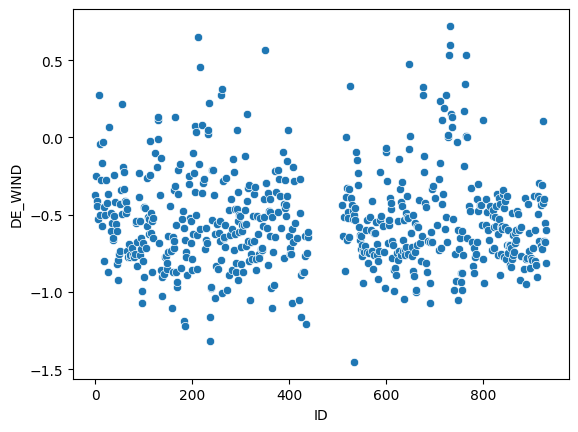

In [7]:
df_wind = de['DE_WIND'].copy()
left_mean = df_wind[df_wind.index < 450].mean()
left_std = df_wind[df_wind.index < 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] - df_wind[df_wind.index > 450].mean()) / df_wind[df_wind.index > 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] * left_std) + left_mean  
sns.scatterplot(x=df_wind.index, y=df_wind)

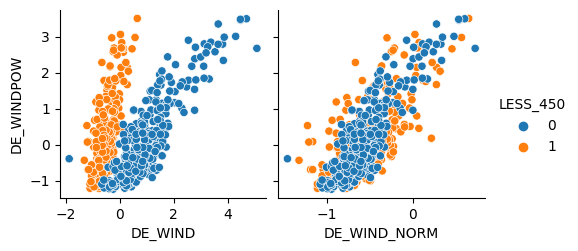

In [8]:
wind_norm = de[['DE_WIND', 'DE_WINDPOW']].copy()
wind_norm['DE_WIND_NORM'] = df_wind
wind_norm['LESS_450'] = 1
wind_norm.loc[wind_norm.index > 450, 'LESS_450'] = 0
sns.pairplot(data=wind_norm, x_vars=['DE_WIND', 'DE_WIND_NORM'], y_vars='DE_WINDPOW', hue='LESS_450')

<Axes: xlabel='ID', ylabel='FR_TEMP'>

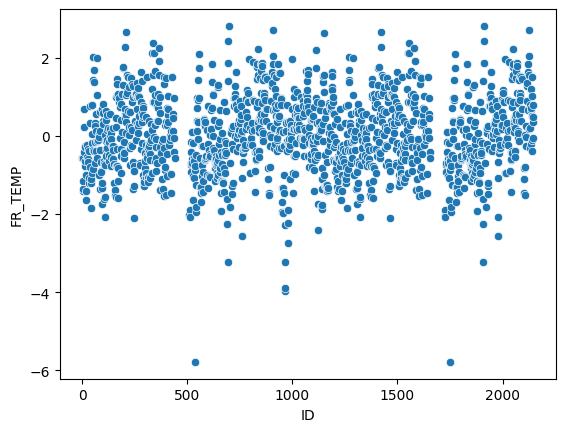

In [9]:
sns.scatterplot(x=df.index, y=df['FR_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

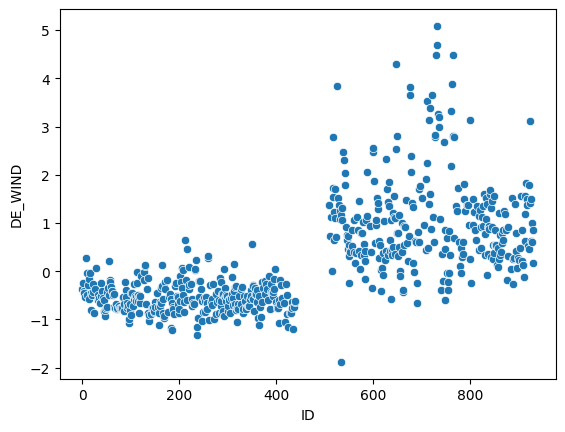

In [10]:
sns.scatterplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

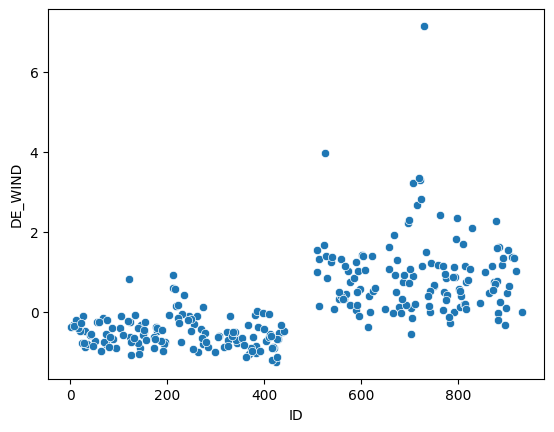

In [11]:
sns.scatterplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

<Axes: xlabel='ID', ylabel='FR_GAS'>

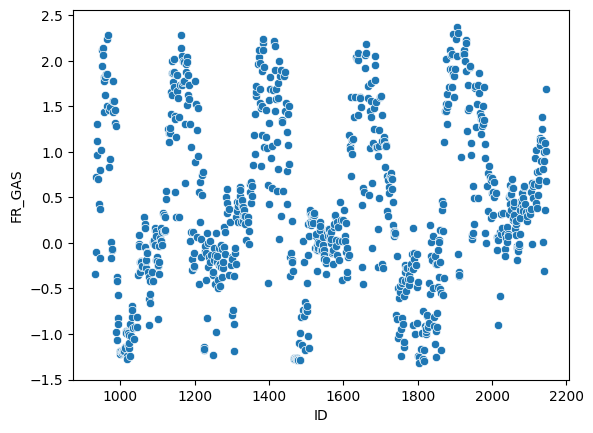

In [12]:
temp_fr = fr.copy()
temp_fr['TARGET'] = y_fr['TARGET']
sns.scatterplot(x=temp_fr.index, y=temp_fr['FR_GAS'])

<Axes: xlabel='ID', ylabel='DE_LIGNITE'>

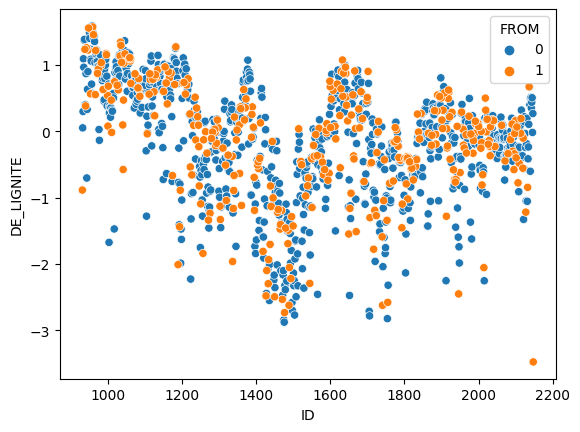

In [13]:
both_fr = fr.append(true_test.loc[true_test['COUNTRY'] == 'FR'])
both_fr['FROM'] = 0
both_fr.loc[true_test[true_test['COUNTRY'] == 'FR'].index, 'FROM'] = 1
sns.scatterplot(x=both_fr.index, y=both_fr['DE_LIGNITE'], hue=both_fr['FROM'])

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994]


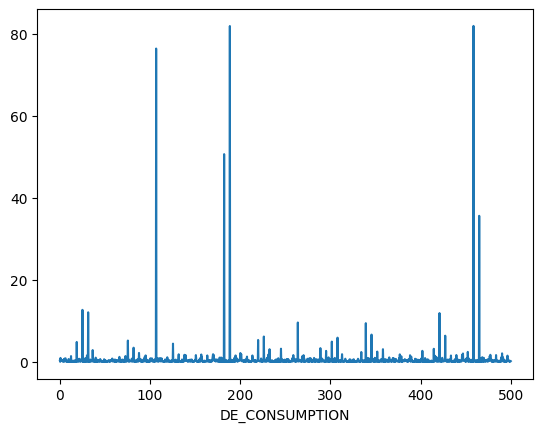

[182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


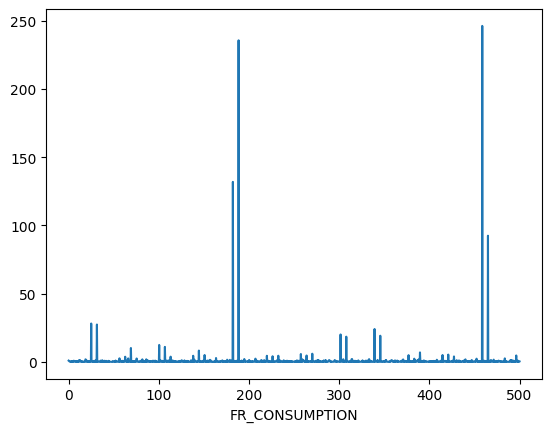

[182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


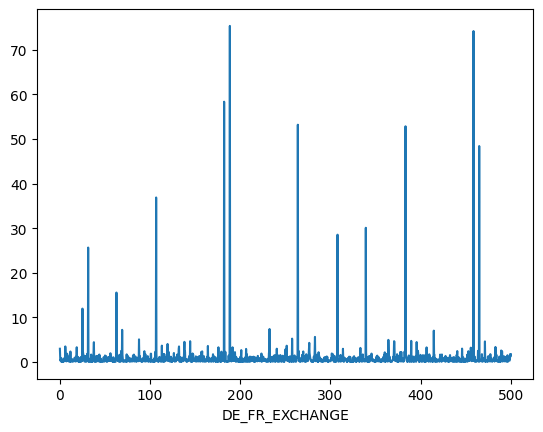

[182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


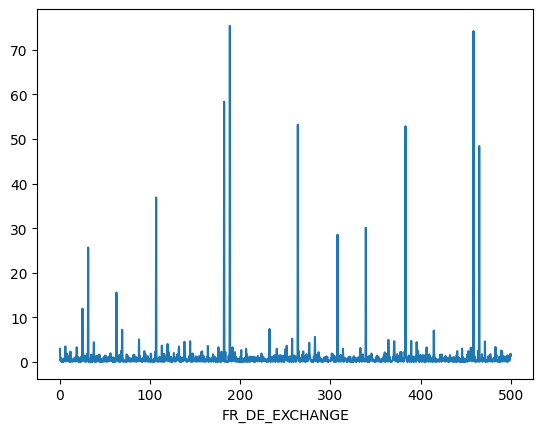

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994]


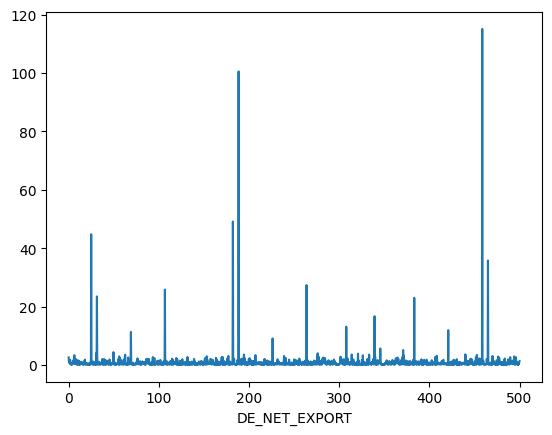

[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]


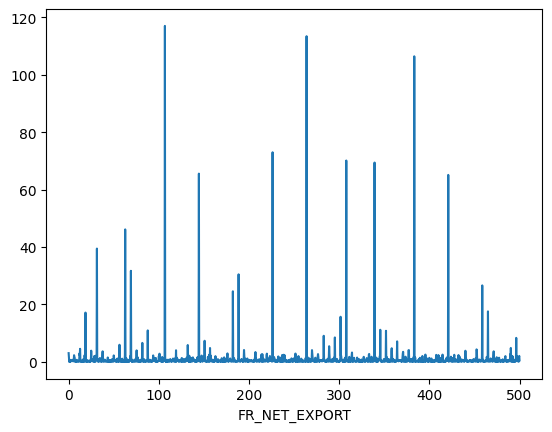

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994]


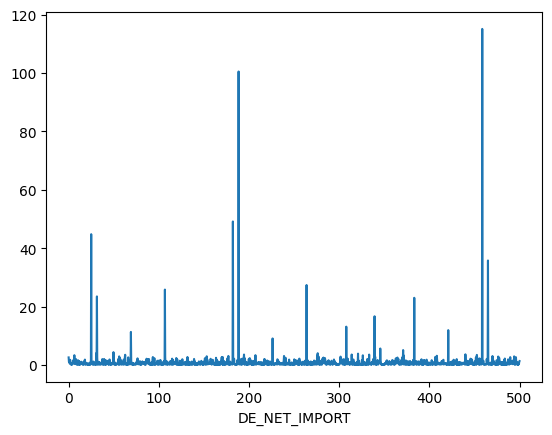

[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]


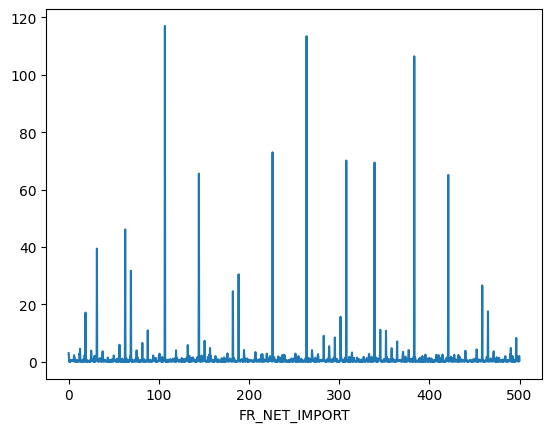

[106.81647765176784, 263.88979319546365, 339.2583055370247, 383.2788525683789]


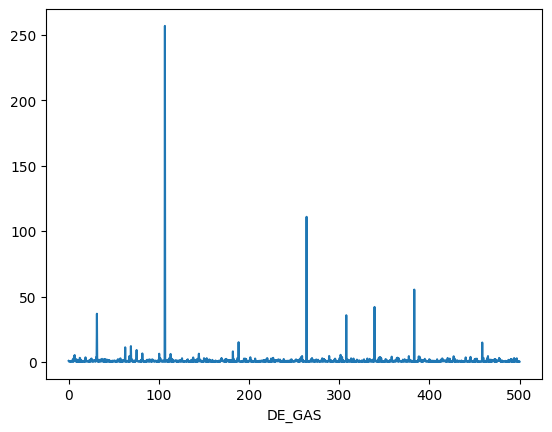

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


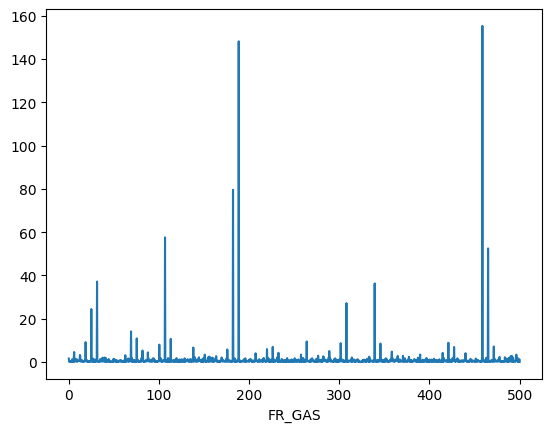

[188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]


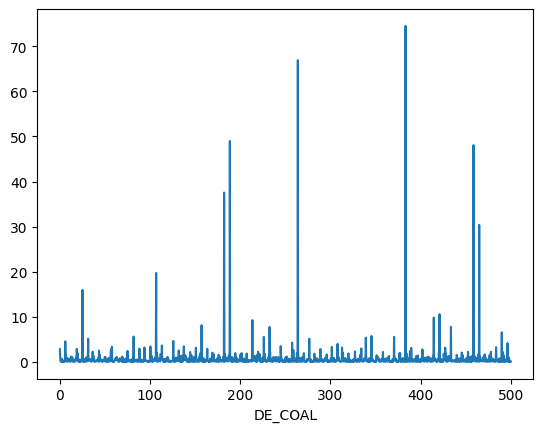

[106.81647765176784]


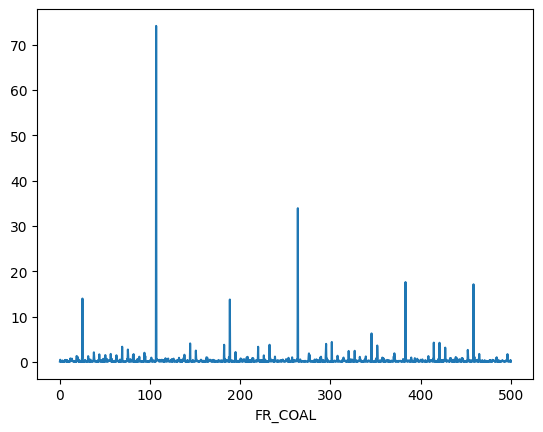

[106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


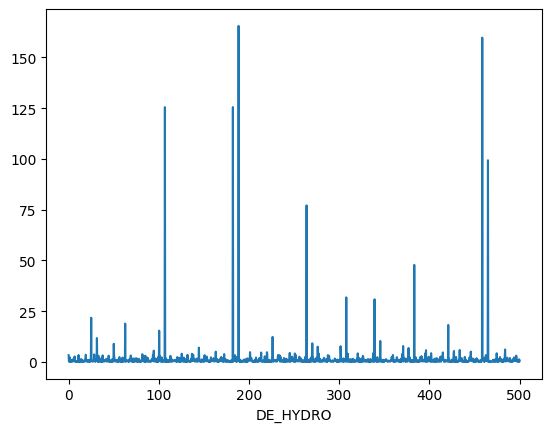

[106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


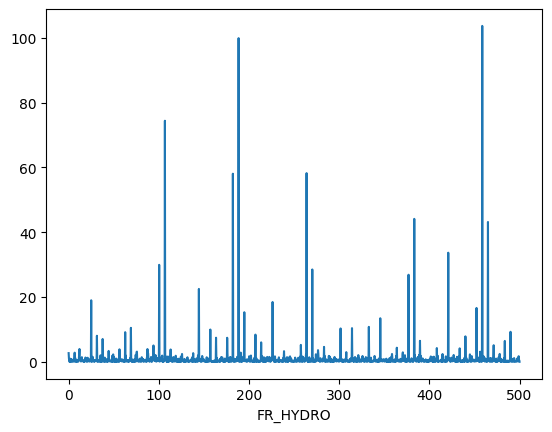

[106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945]


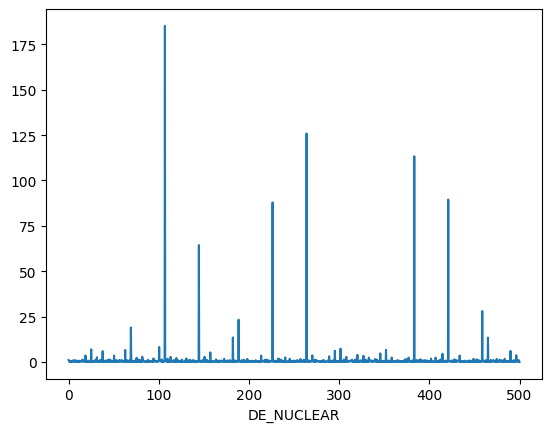

[106.81647765176784, 144.50073382254837, 182.18498999332888, 188.5212808539026, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945, 458.64736490994, 464.9836557705137]


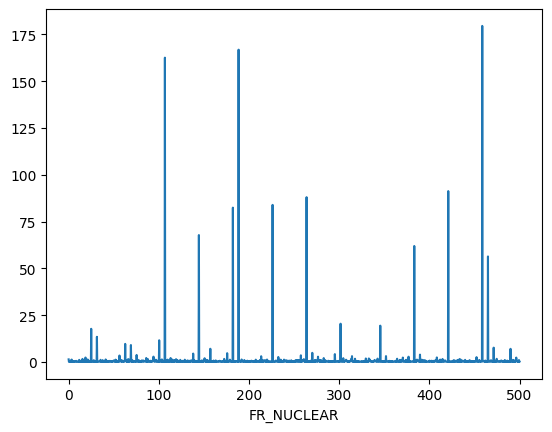

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


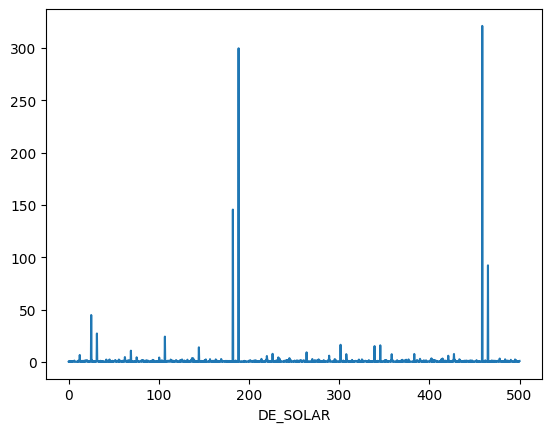

[25.11167444963309, 106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 458.64736490994, 464.9836557705137]


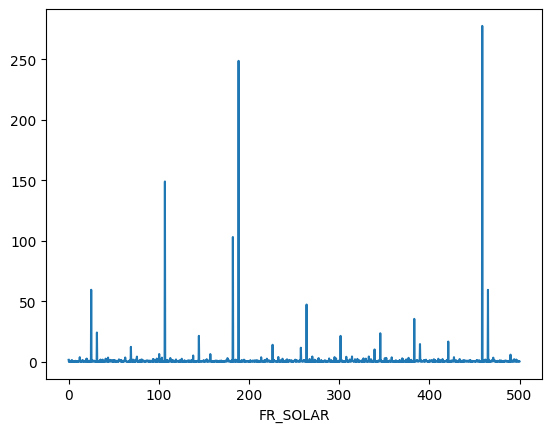

[182.18498999332888, 188.5212808539026, 458.64736490994]


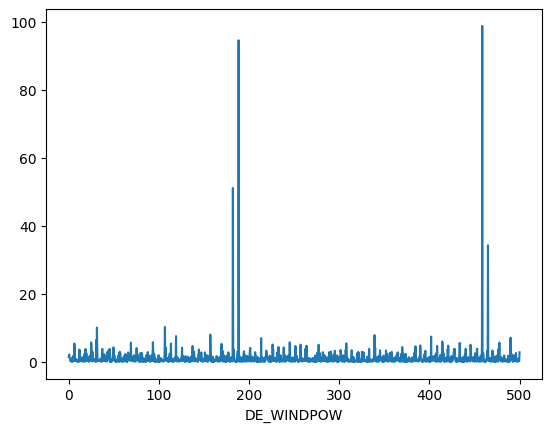

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


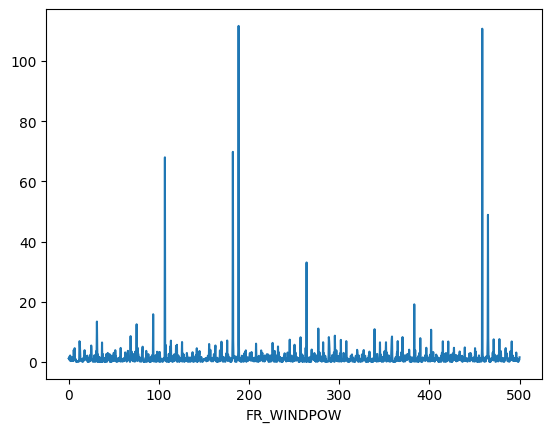

[106.81647765176784, 263.88979319546365, 383.2788525683789]


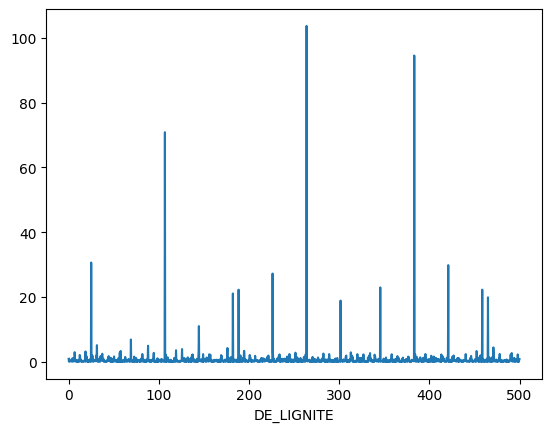

[]


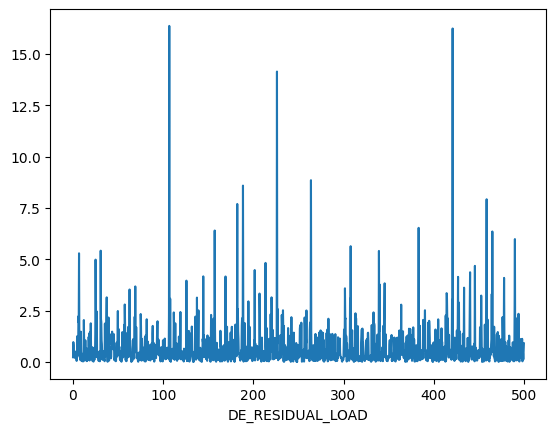

[182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


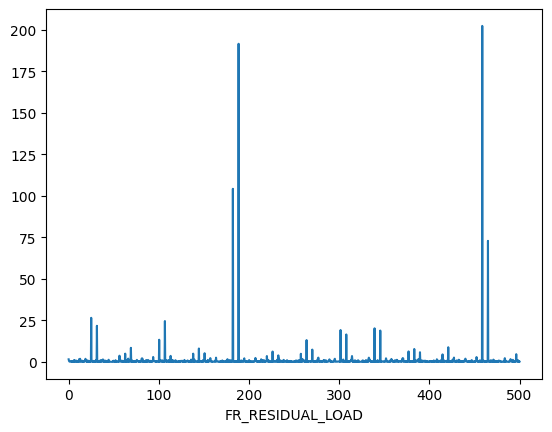

[]


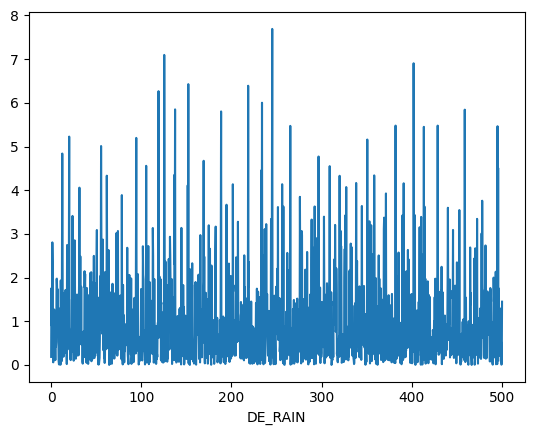

[]


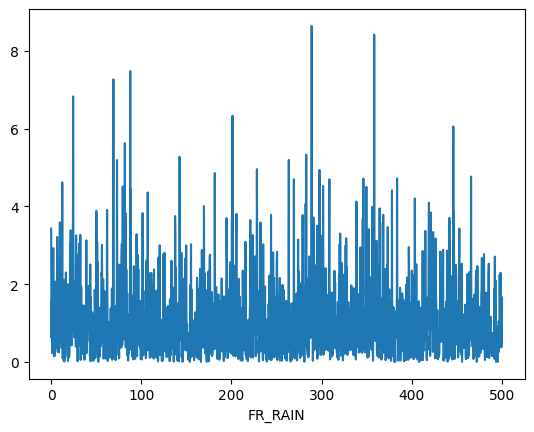

[106.81647765176784, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945]


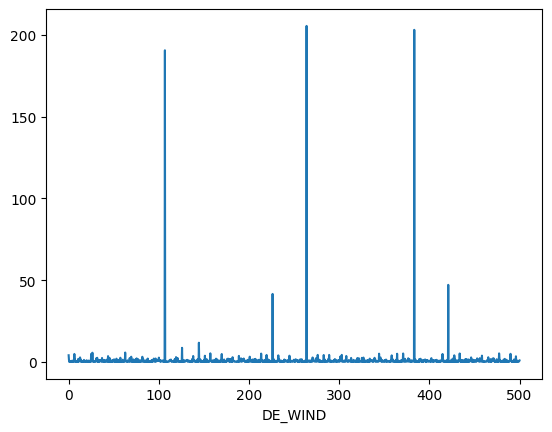

[106.81647765176784, 263.88979319546365, 383.2788525683789]


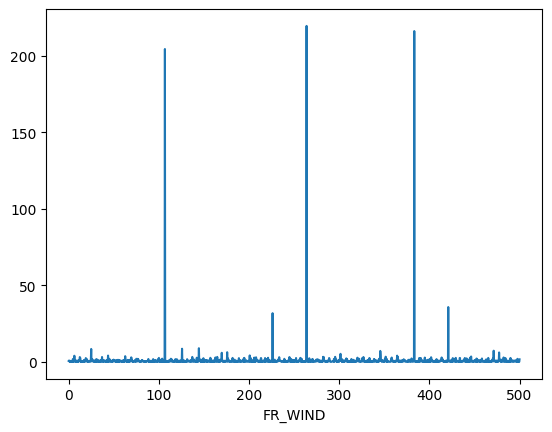

[]


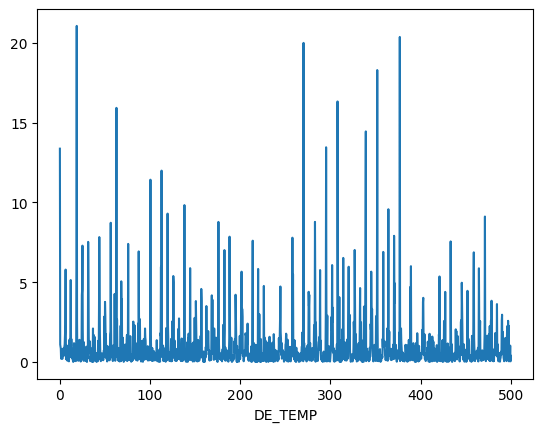

[]


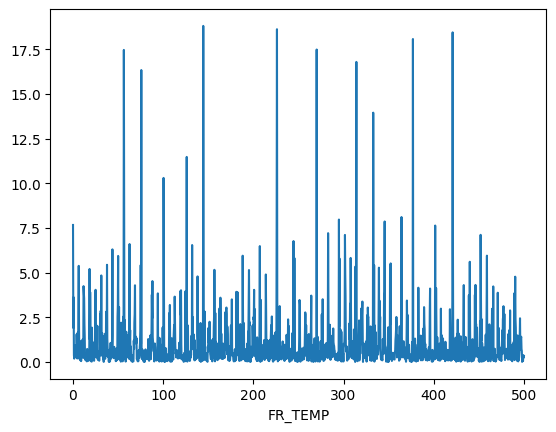

[]


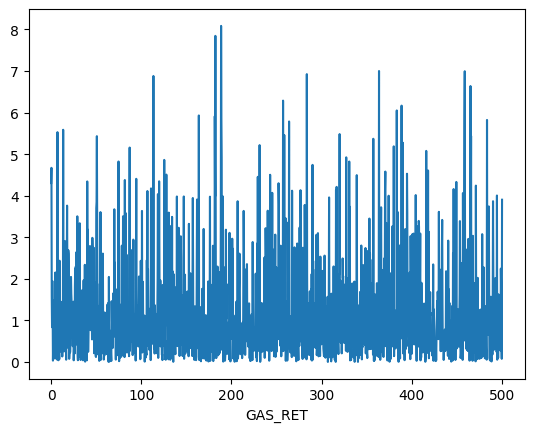

[]


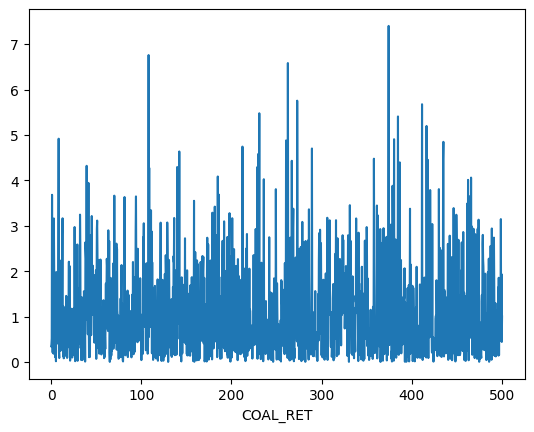

[]


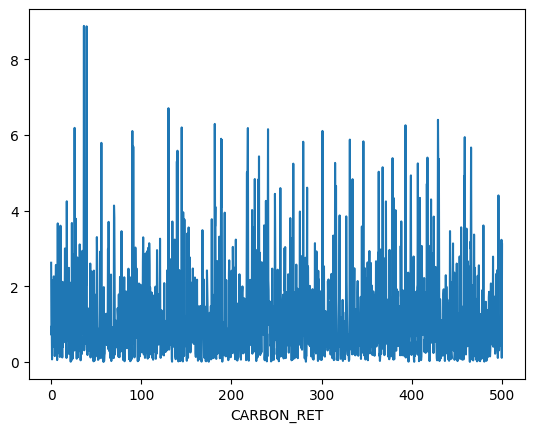

In [14]:
fs = np.linspace(0.1, 500, 1500)
for col in fr.drop(['DAY_ID', 'COUNTRY'], axis=1).columns:
    plt.figure()
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 40).ravel()])
    p = sns.lineplot(x=fs, y=pgram)
    p.set(xlabel=col)
    plt.show()

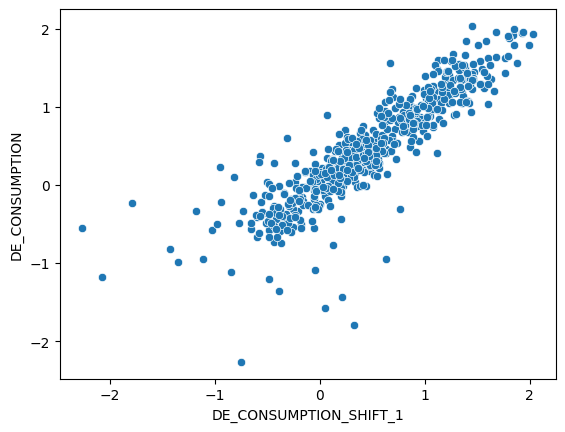

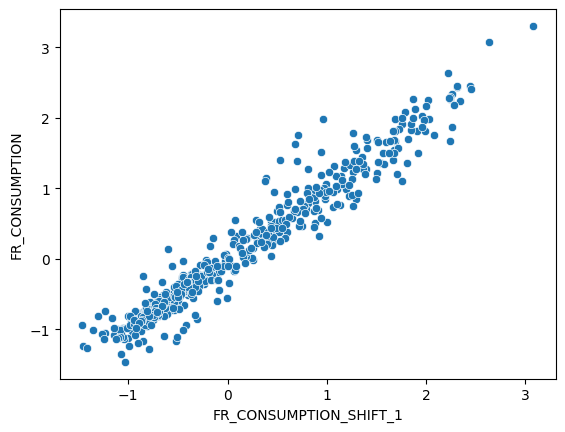

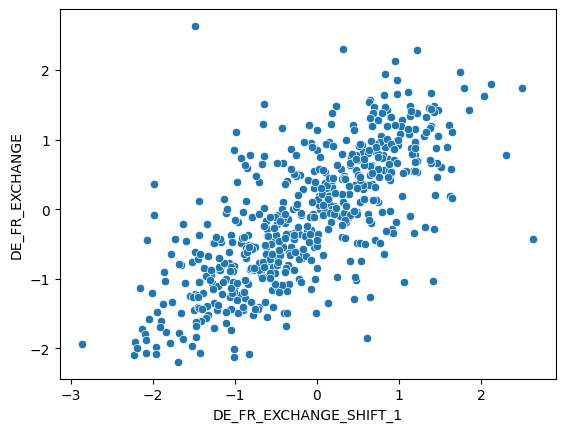

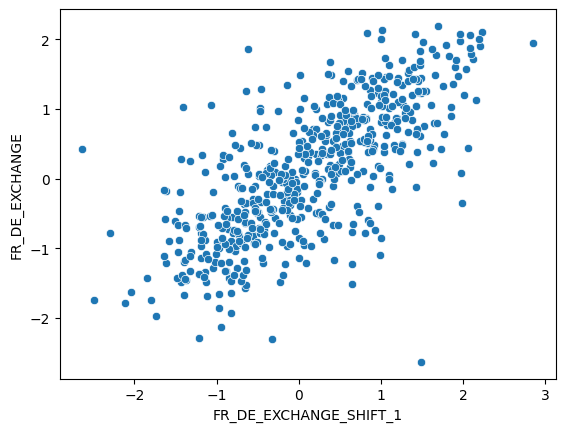

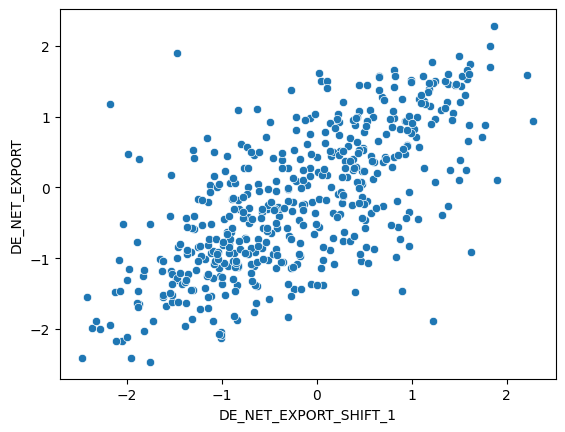

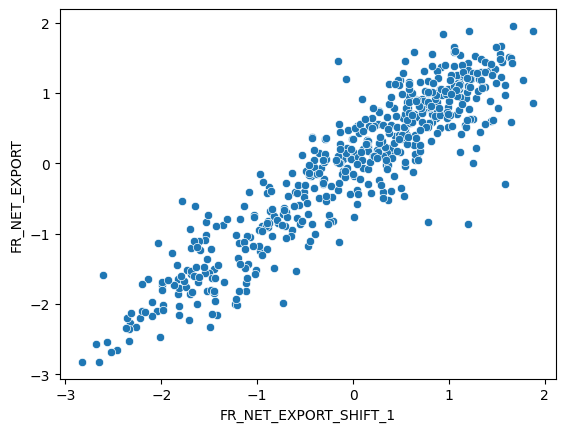

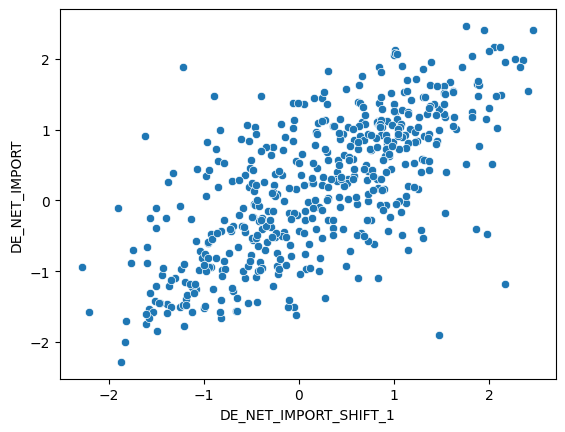

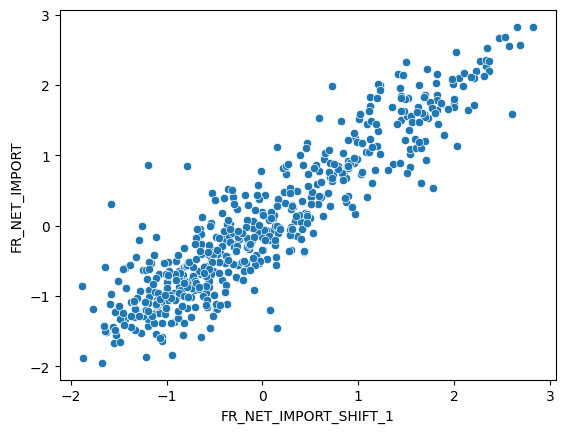

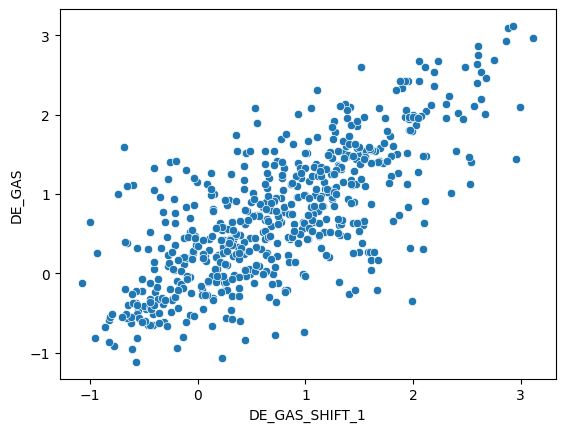

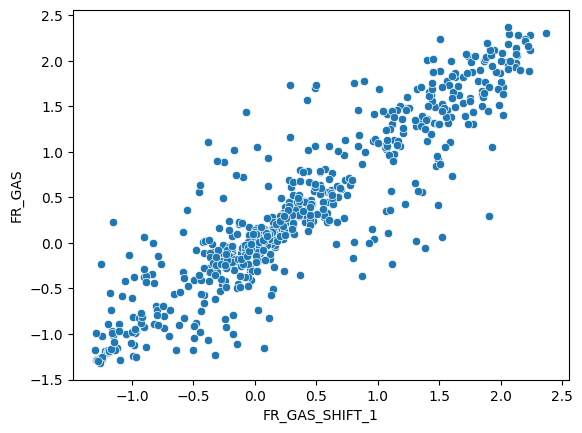

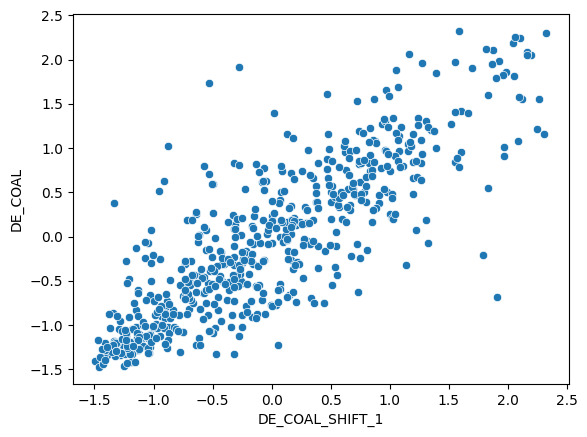

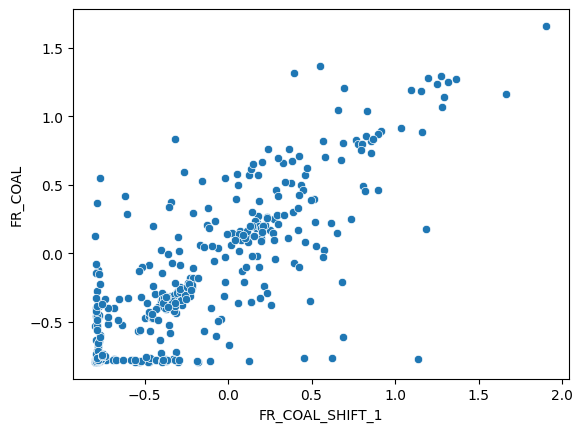

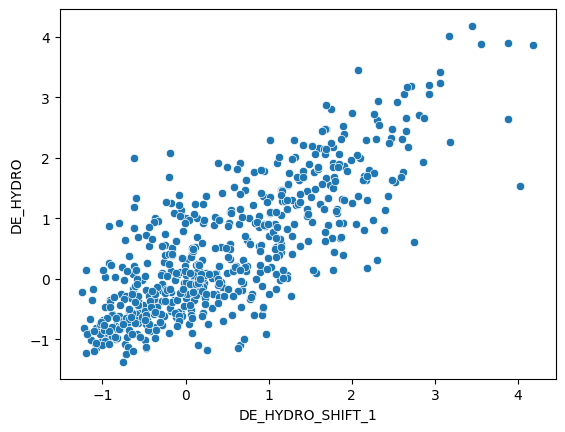

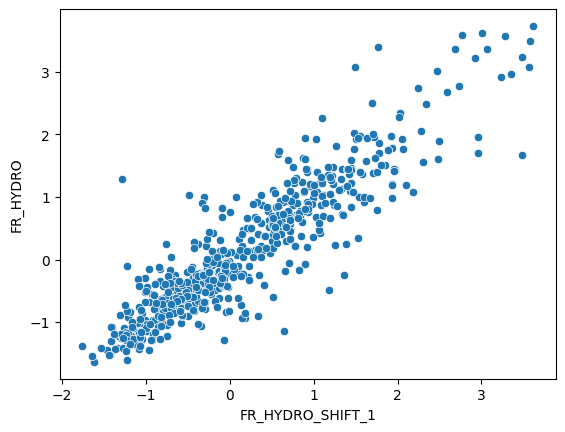

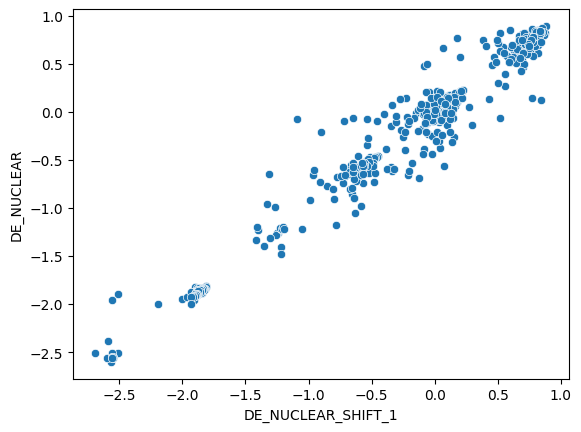

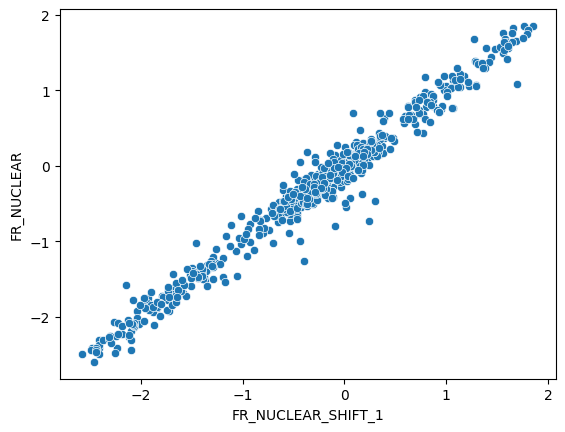

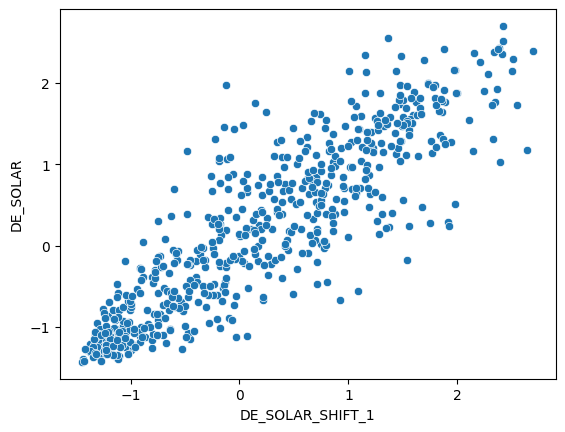

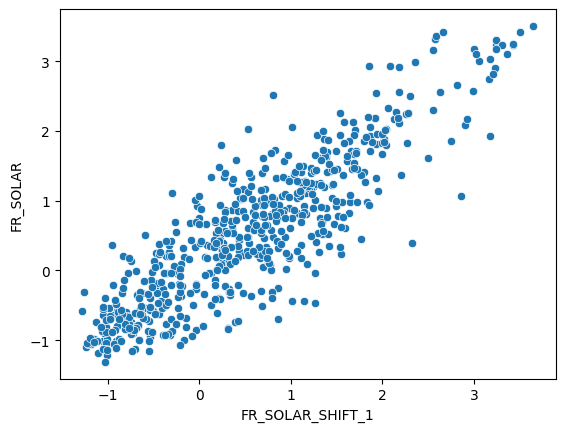

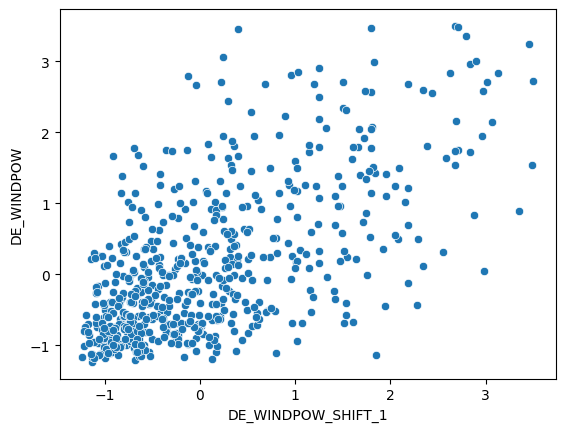

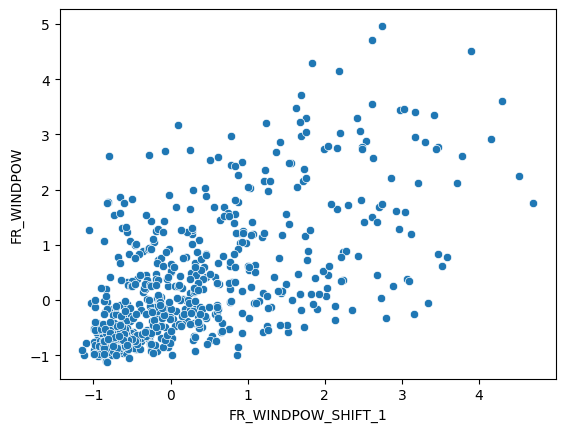

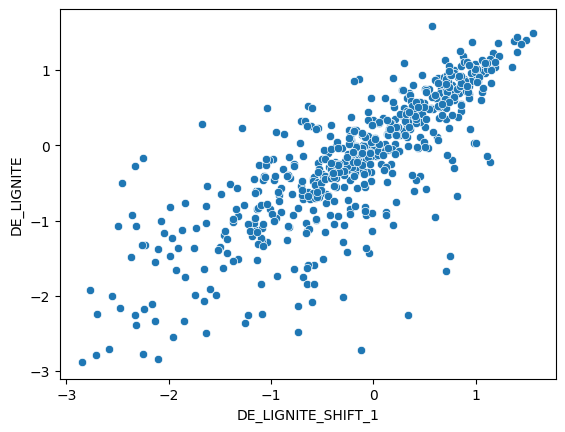

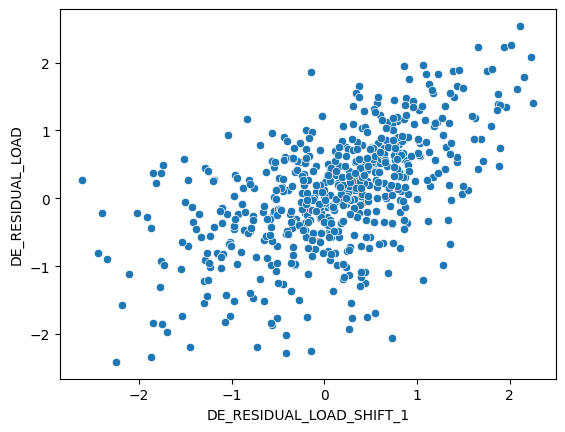

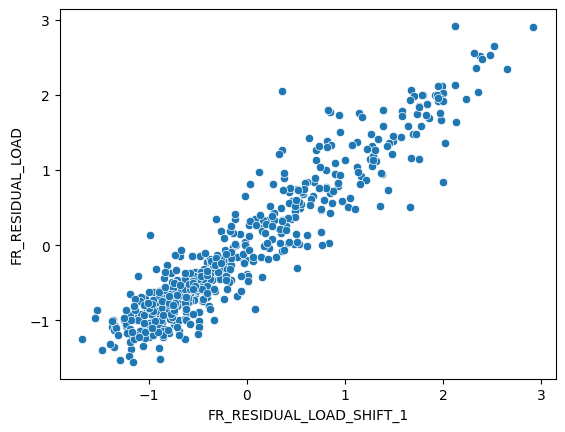

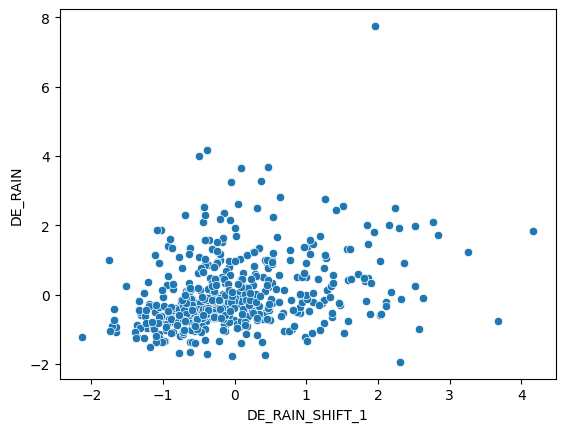

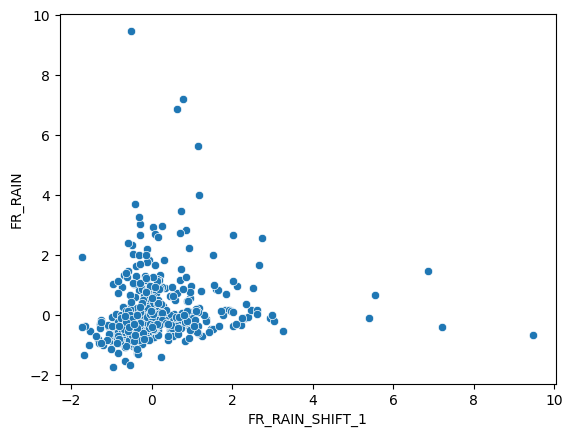

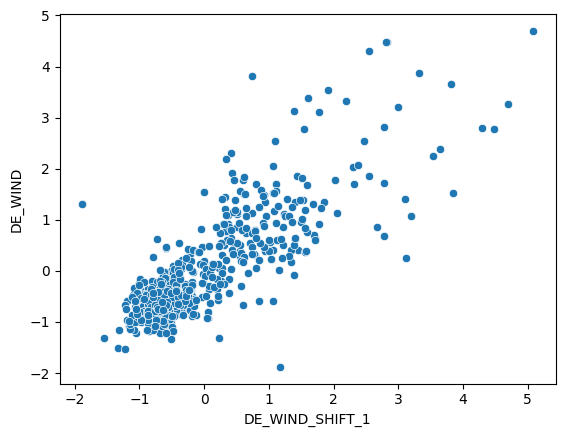

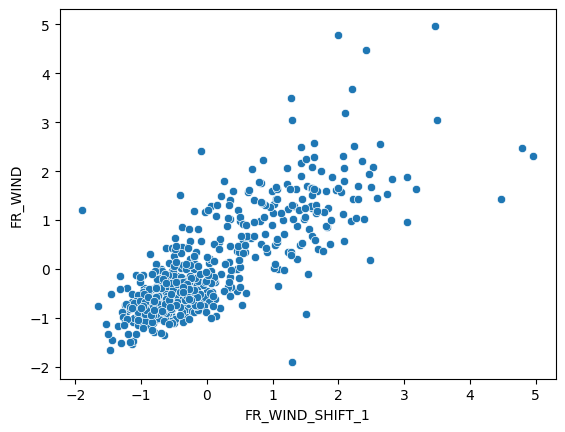

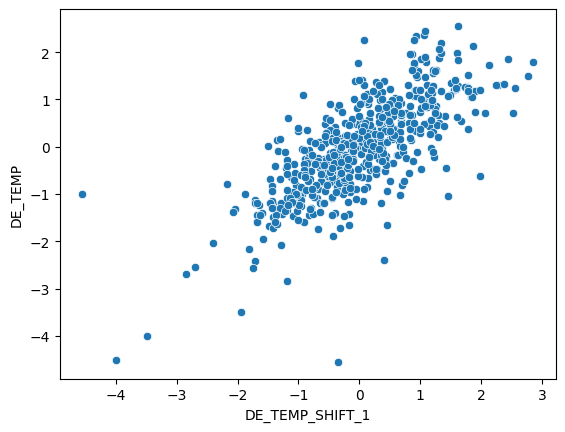

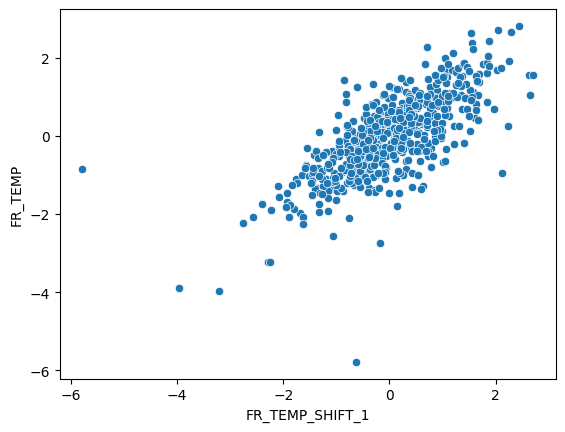

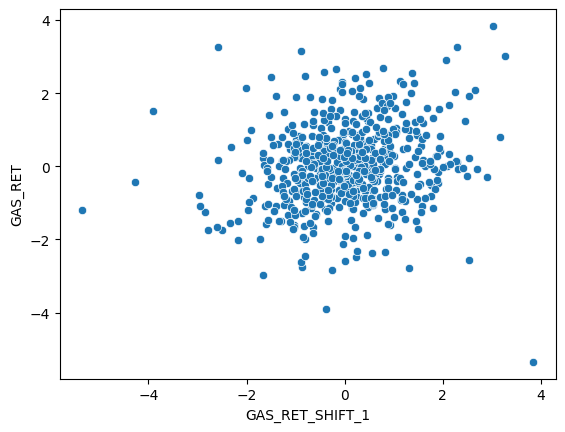

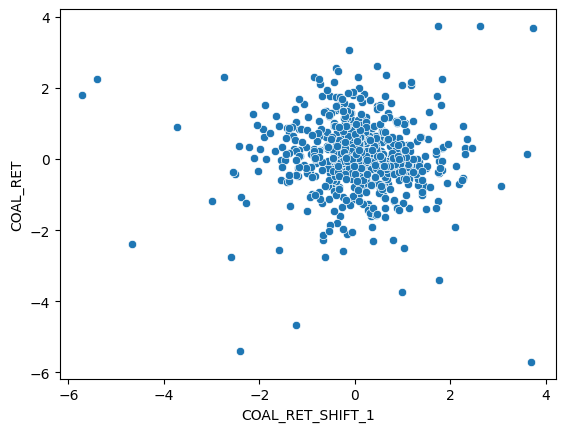

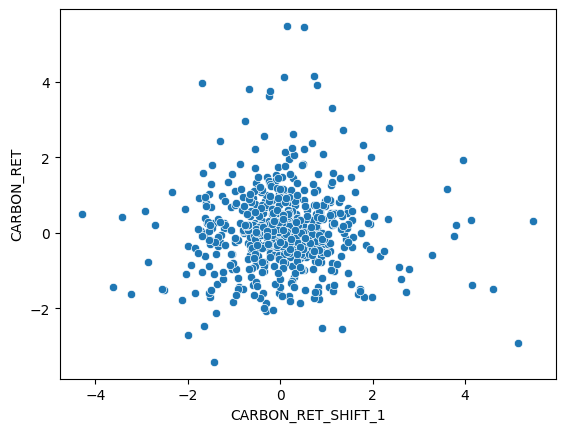

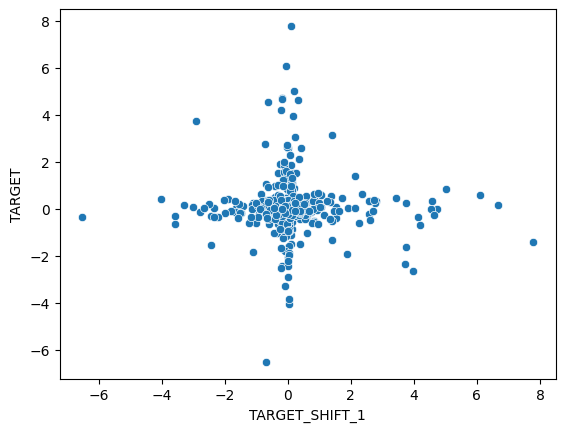

In [49]:
temp_fr = fr.copy()
temp_fr['TARGET'] = y_fr['TARGET']
for col in temp_fr.drop(['DAY_ID', 'COUNTRY'], axis=1).columns:
    for i in range(1, 2):
        plt.figure()
        temp = temp_fr[col].copy().sort_index()
        temp_shifted = temp.shift(i)
        idx = temp.index.intersection(temp.index + i)
        p = sns.scatterplot(x=temp_shifted[idx], y=temp[idx])
        p.set(xlabel=f"{col}_SHIFT_{i}")
        plt.show()

In [16]:
idx

Int64Index([ 934,  935,  936,  937,  938,  945,  946,  947,  951,  952,
            ...
            2135, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146],
           dtype='int64', name='ID', length=588)

In [17]:
temp_shifted

ID
933          NaN
934    -0.174539
935     4.724418
936     0.001284
937    -0.142445
          ...   
2142    0.117021
2143    0.957628
2144    0.687808
2145   -0.083983
2146   -0.176865
Name: TARGET, Length: 851, dtype: float64

In [18]:
temp_fr

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
933,992,FR,0.880508,0.881603,NaN,NaN,NaN,NaN,NaN,NaN,0.066808,-0.344762,-0.006085,-0.776396,-0.576288,0.554155,0.663309,1.283956,-1.399163,-1.235034,1.413867,2.436178,0.050227,-0.192107,0.427023,2.034344,2.127580,-0.205264,0.123975,1.075974,1.835761,-0.355296,-0.301449,-0.220830,-0.174539
934,740,FR,0.683673,0.813651,NaN,NaN,NaN,NaN,NaN,NaN,0.223300,-0.097421,0.166830,-0.778026,-0.731163,0.831906,0.520983,1.386685,-1.279730,-1.100344,1.107618,0.801223,0.296333,-0.093060,0.702082,0.979414,0.967726,-0.365213,-0.608444,1.465248,1.605309,0.317321,0.050629,-0.551201,4.724418
935,52,FR,1.231695,1.269656,NaN,NaN,NaN,NaN,NaN,NaN,0.541972,0.726137,-0.262330,-0.121198,-1.075728,0.690618,0.820342,1.557844,-1.122654,-1.179317,1.251842,0.322378,1.091601,0.097374,1.264296,-1.228214,0.962364,-0.462356,-0.364924,-1.044338,0.456897,0.078996,-0.606772,0.270359,0.001284
936,28,FR,1.408520,1.391108,NaN,NaN,NaN,NaN,NaN,NaN,0.736501,0.963235,0.019075,0.327328,-0.820520,0.932772,0.689873,1.760980,-1.134702,-1.054363,1.072079,-0.158598,0.963711,0.377162,1.486483,-0.967634,0.555446,-0.510427,-0.985396,-0.885387,-0.298126,-0.236740,0.616277,0.787153,-0.142445
937,65,FR,1.075988,1.276328,NaN,NaN,NaN,NaN,NaN,NaN,1.414906,1.116439,1.391492,0.658796,-0.682110,0.756215,0.812531,1.854408,-1.024976,-1.006239,-0.683238,-0.277055,1.369470,1.659356,1.391707,-0.679139,0.036572,-1.324837,-0.784565,-0.282143,0.513167,-0.435396,0.556208,0.131572,-0.100006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,701,FR,1.032122,0.383270,0.451691,-0.451691,0.437667,-1.106814,-0.437667,1.106814,0.533996,1.097201,0.568480,-0.216372,-0.473725,-0.883788,-1.914119,-1.489547,-1.120453,-0.213344,1.023247,3.298833,0.347272,0.163624,-0.322860,-0.042241,0.517631,1.506315,2.584335,-1.225979,-0.113555,0.785530,-0.322581,0.362803,0.957628
2143,112,FR,0.979093,0.338229,1.138619,-1.138619,0.480707,-1.631364,-0.480707,1.631364,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.086420,0.643169,1.007158,1.445712,-0.107380,-0.046727,0.961630,0.891689,1.012246,0.687808
2144,102,FR,1.009837,0.237311,-0.093751,0.093751,-0.425785,-1.194162,0.425785,1.194162,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,0.213069,-0.442086,0.601170,1.439691,0.047149,0.364089,-0.784590,1.046452,-0.545607,-0.083983


In [19]:
fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((basic_clean(df)))))))

,COUNTRY,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,EXCHANGE,SELF_EXPORT,OTHER_EXPORT,SELF_CONSUMPTION,OTHER_CONSUMPTION,DE_WIND_SQCB,FR_WIND_SQCB,DE_GAS_COST,DE_GAS_CARBON,DE_COAL_COST,DE_COAL_CARBON,FR_GAS_COST,FR_GAS_CARBON,FR_COAL_COST,FR_COAL_CARBON,DE_LIGNITE_CARBON,SIN_365_1,COS365_1,SIN_365_2,COS365_2,SIN_365_3,COS365_3,TIME
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,-0.047033,-0.248052,-0.466573,-0.558732,1.602466,1.527066,1.790950,0.778353,0.931374,-0.188162,0.583923,0.276131,1.316022,1.033323,1.340833,1.498543,0.306365,0.359306,0.077138,0.086211,-1.186828,-1.391917,1.120973,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0
2,0,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,-0.274901,-0.347173,-1.817422,-1.163299,1.596267,1.409234,0.593396,-0.179177,0.588670,0.395241,0.548187,0.343348,1.386017,1.457874,1.696522,0.630664,0.412847,0.173840,-0.237891,-0.088433,-0.610907,-0.257238,0.429015,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,2
3,0,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,-0.672022,-0.421214,-2.170678,-1.399423,0.172622,-0.847545,-0.313360,-0.707035,0.111881,0.536853,0.470907,0.346433,1.293390,1.401205,0.211137,-0.383276,-0.127657,-0.047198,0.129672,-0.235393,0.661372,0.244527,-0.221792,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,3
4,0,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-0.300883,-0.148592,-0.795390,-1.352885,-1.951199,0.273857,-1.847703,0.389806,1.506291,-0.035824,0.284447,0.356063,1.272833,1.174664,-0.395494,-0.374516,-0.182345,1.230275,-1.032525,-0.977758,-0.212218,1.431831,-0.924191,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,4
5,0,0.637224,0.780458,-0.746381,-0.780286,-0.014076,-0.507558,0.131863,0.297371,1.377499,0.117900,0.639742,-0.407567,0.247893,-0.613143,0.335134,-0.347601,0.035837,-0.511760,-0.562027,-0.307876,0.225957,-0.408372,0.226737,1.205343,0.067784,0.551274,0.256555,1.221623,0.999345,-0.196186,-0.260225,-0.168650,0.304801,-0.240284,-0.318717,-0.176311,0.318647,-0.101233,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,1,0.533996,1.097201,0.568480,-0.216372,-0.473725,-0.883788,-1.914119,-1.489547,-1.120453,-0.213344,1.023247,3.298833,0.347272,0.163624,-0.322860,-0.042241,0.517631,-1.225979,-0.113555,0.785530,-0.322581,0.362803,-0.451691,-1.106814,0.437667,0.383270,1.032122,2.255212,2.717459,0.419470,0.193735,-0.183381,0.206246,0.861884,0.398068,0.069797,-0.078500,0.125991,-0.735417,0.677615,-0.996659,-0.081676,-0.615285,-0.788305,2142
2143,1,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.086420,0.643169,-0.107380,-0.046727,0.961630,0.891689,1.012246,-1.138619,-1.631364,0.480707,0.338229,0.979093,2.027787,2.234877,0.425446,0.447839,0.700450,0.795151,0.353173,0.371762,-0.209424,-0.237738,0.442233,-0.723644,0.690173,-0.998880,-0.047321,-0.655156,-0.755493,2143
2144,1,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,0.213069,-0.442086,0.047149,0.364089,-0.784590,1.046452,-0.545607,0.093751,-1.194162,-0.425785,0.237311,1.009837,1.832961,2.232191,-0.624715,-0.434430,0.905900,-0

<Figure size 640x480 with 0 Axes>

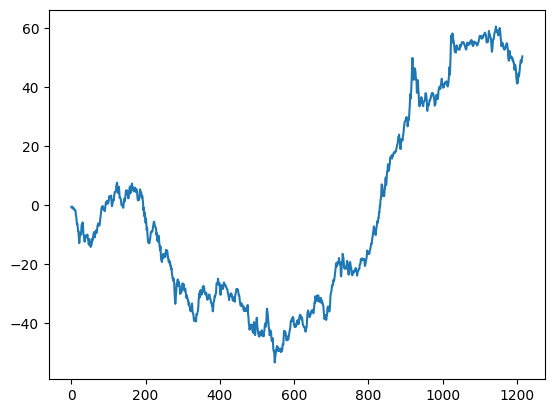

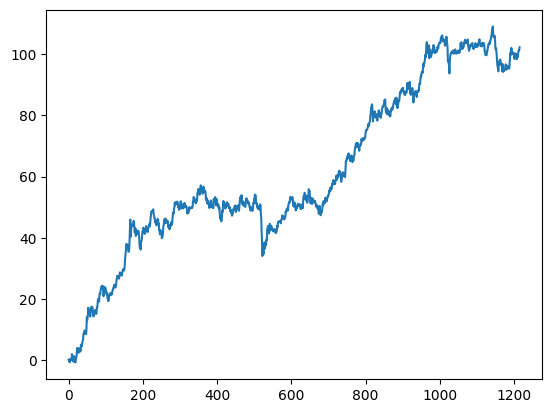

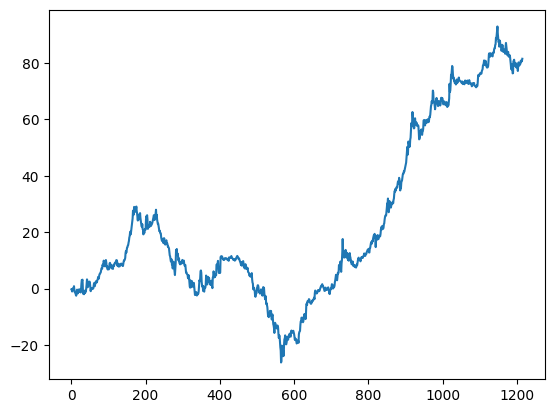

In [20]:
temp = fr[['GAS_RET', 'COAL_RET', 'CARBON_RET']].copy()
temp = temp.append(true_test.loc[true_test['COUNTRY'] == 'FR', ['GAS_RET', 'COAL_RET', 'CARBON_RET']]).sort_index()
gas = [0]
coal = [0]
carbon = [0]
prices = [gas, coal, carbon]
for row in temp.itertuples(index=False):
    for i in range(3):
        prices[i].append(prices[i][-1] + row[i])
for i in range(3):
    prices[i].pop(0)
plt.clf()
for p in prices:
    plt.figure()
    sns.lineplot(x=range(len(p)), y=p)

<Axes: xlabel='ID'>

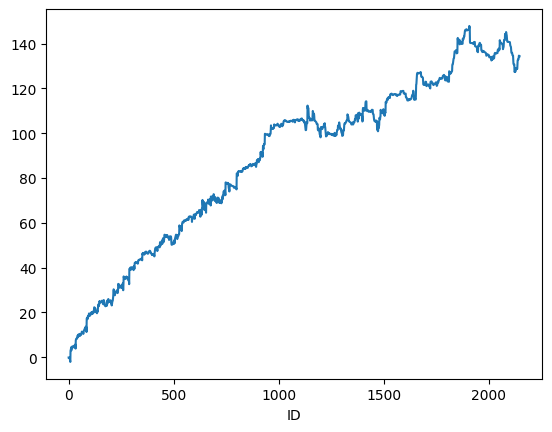

In [21]:
energy = [0]
for row in y.itertuples(index=False):
    energy.append(energy[-1] + row[0])
energy.pop(0)
sns.lineplot(x=y.index, y=energy)

### Benchmarking
Running linear regression on the same train test split for a basic performance benchmark. For now we just replace NaN values with 0.

In [22]:
br_lr = LinearRegression()

br_x_train_clean, br_x_test_clean = bx_train.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1), bx_test.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1)
y_train_clean, y_test_clean = by_train['TARGET'], by_test['TARGET']

test_model(br_lr, br_x_train_clean, br_x_test_clean, y_train_clean, y_test_clean)

fit on test set: 23.6%
fit on training set: 26.8%



(array([ 7.29265737e-02,  3.50514120e-01,  6.63566499e-02,  1.14325006e-01,
         2.87391736e-01,  2.25479587e-01, -9.24319396e-03, -9.48980331e-02,
        -1.58381788e-01,  2.84951181e-01, -2.95344317e-01,  3.57920820e-01,
        -1.13317100e-01,  1.59812050e-01,  2.50583784e-01, -5.56315631e-01,
        -2.45102069e-01, -1.22478802e-01,  2.97163443e-01,  4.63360292e-01,
         8.66189715e-02,  3.77441423e-01,  8.65506543e-01,  6.14460480e-03,
         1.42907486e-01, -2.70748564e-02, -6.91611216e-02,  2.50767002e-01,
        -1.05310439e-01, -6.34790026e-02,  1.99599850e-01,  2.25203934e-01,
         1.39097012e-01,  2.30811355e-01,  1.01828152e-01,  1.82469160e-02,
         5.05333486e-01,  1.18744375e-01,  1.92085497e-01,  2.50583784e-01,
         9.19680718e-02,  9.92185036e-02,  3.99156483e-01,  2.75968304e-01,
         1.21283006e-01,  5.40762624e-01, -1.39931504e-01, -2.16358126e-01,
         1.80743659e-01,  4.22247024e-02,  8.97494133e-02, -4.05986349e-02,
         1.0

### Exploratory Data Analysis

Windpower has a threshold value for wind levels, where past a certain point we have a new line because one kind of turbine reaches its cut-out speed as another reaches its cut-in: https://energyeducation.ca/encyclopedia/Wind_power. The site claims that there is a cubic relationship between wind speed and power generation between its cut-in and rated speeds, though I don't really see one when plotting. Instead, I found that the most reasonable transformation was the cube root of wind speed squared—windspeed measures the flow of volume, while wind turbines can be approximated as a 2d surface with some constant energy generation per unit area.

Temperature should affect photovoltaic energy generation as there is a correlation between sunlight and temperature (cloud cover would reduce both temperature and sunlight, for example), and since high temperatures would cause solar panels to decline in performance (increasing resistance, damaging parts), potentially to the point of not being operable. This is perhaps made up for by other means of solar energy production, notably the use of solar energy to evaporate water into steam for turbine based generators. Overall though, this empirically seems to be less important in comparison to other factors though not negligible (Germany uses solar for roughly 10%, France 20%).

May be something to revisit, though at the moment it seems like temperature is most useful for calculating energy consumption, as the most energy intensive (residential) use is in heating and cooling, hence we may expect some kind of relationship between the mean squared distance temperature is from the ideal indoor temperature and energy consumption.

Germany has 3 nuclear reactors (which will be shutting down soon), hence the vertical bands produced in the graphs related to DE_NUCLEAR: the eight combinations of reactors (which may individually have different output levels) account relatively well for the structure of the plots. Additionally, the number of active reactors may be indicative of other conditions, as reactors may be used to make up for insufficient production elsewhere (i.e. during periods of low wind or sunlight).

On the other hand, France has 56, so the bands aren't present, though we do see a clear trend in nuclear energy production when consumption and thus demand is higher—this is easily explained by the vast majority of energy in France being from nuclear energy (in the 70 something percent range). Something of note in French energy production, however, is the use of coal: similar to German nuclear energy, it seems to be put into use only when needed, as there are a large amount of points at the minimum value of FR_COAL, implying certain conditions where coal energy is not being produced at all.

These observations are notable, as they present a clear difference in the analysis of energy production between countries, as well as that of renewable and non-renewable means: energy production based on natural factors (wind, hydroelectric, photovoltaic) are for the most part in reaction to conditions outside of human control, with the exception of thresholds such as cut-in and cut-out times of wind turbines that simply halt or begin production in reaction to external factors, which otherwise control the rate. On the other hand, energy produced by consumption of non-renewable resources such as gas or coal is entirely in the control of the country, which must decide whether to activate certain plants or not. Since electricity prices are heavily influenced by excess energy (see "Nonlinear Excess Demand Model for Electricity Price Prediction", Soytas et. al.), it seems reasonable to predict price fluctuations in energy by the excess or insufficient energy produced by renewable means, as these factors are the most unpredictable and therefore most likely to cause an over- or underproduction of electricity.

In [25]:
df_numeric.columns

Index(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [26]:
df_numeric.describe()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,0.427442,-0.020032,-0.145822,0.260529,0.064580,0.780699,0.395019,-0.134330,-0.434518,0.537398,0.105639,-0.468190,-0.446805,0.246707,0.608185,0.146337,0.398426,-0.298856,0.071633,-0.153688,-0.052747,0.003785,0.086134,0.100944,0.007201,0.006561,0.058126,0.061724,0.080510
std,0.673412,0.918995,0.962071,0.916927,1.050937,0.850190,0.906500,0.847285,0.506141,1.086330,1.057867,0.902468,0.964543,1.069899,1.079398,1.064187,1.189404,0.851339,0.851499,0.896325,0.954484,1.019906,1.026417,1.024526,0.941325,0.971283,1.097768,1.033853,1.098624
min,-2.265563,-1.462350,-2.856874,-2.279619,-1.951516,-1.117260,-1.317350,-1.491593,-0.794950,-1.373985,-1.758523,-2.689387,-2.595326,-1.442296,-1.312588,-1.235802,-1.143277,-2.879041,-2.613569,-1.678936,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790
25%,-0.037421,-0.716771,-0.869990,-0.395910,-0.774676,0.134947,-0.205078,-0.833046,-0.779098,-0.314520,-0.693892,-0.954908,-1.228912,-0.731345,-0.311343,-0.688284,-0.527749,-0.787239,-0.422896,-0.802333,-0.618791,-0.488625,-0.633867,-0.645796,-0.577139,-0.597690,-0.624238,-0.458038,-0.522968
50%,0.357061,-0.394166,-0.164287,0.306899,-0.099455,0.740006,0.256780,-0.246732,-0.766389,0.330832,-0.138049,-0.097032,-0.327874,0.211219,0.566797,-0.091336,0.007051,-0.188300,0.151799,-0.460160,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056
75%,0.922057,0.650533,0.631683,0.921263,0.820640,1.399461,1.090646,0.485761,-0.262886,1.282374,0.776483,0.100720,0.143426,1.158397,1.368670,0.644247,1.010071,0.273510,0.621209,0.382191,0.274779,0.125947,0.587377,0.677040,0.569285,0.650856,0.676415,0.641446,0.599094
max,2.033851,3.300640,2.634831,2.464849,2.825331,3.118082,2.372570,2.324889,1.905512,4.181936,3.730478,0.893087,1.854408,2.696571,3.648905,3.509017,4.965793,1.586885,2.539576,2.918326,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818


### Feature Engineering

In [27]:
km = KMeans(n_clusters=2)
km.fit(df_numeric)
km.labels_
df_clustered = df_numeric.copy()
df_clustered['CLUSTER'] = km.labels_
# sns.pairplot(data=df_clustered, vars=['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
#       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
#       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
#       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
#       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
#       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'], hue='CLUSTER')

In [28]:
y

,TARGET
ID,
0,-0.163530
2,0.010774
3,-0.233505
4,0.029822
5,-0.073464
...,...
2142,0.957628
2143,0.687808
2144,-0.083983


### Models

In [29]:
kf = KFold(n_splits = 10)

Trying various models.

TODO read through and implement stuff from here, paper notes that drivers of electricity prices are nonlinear: https://www.sciencedirect.com/science/article/pii/S0301421518307432

In [30]:
x_fr = fuel_cost(make_wind_sqcb(country_flow((basic_clean(fr)))).drop('COUNTRY', axis=1))
x_de = fuel_cost(make_wind_sqcb(country_flow((basic_clean(de)))).drop('COUNTRY', axis=1))

In [54]:
x = fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((basic_clean(de))))))) \
#    .drop(['DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO',
 #      'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'GAS_RET', 'COAL_RET', 'DE_RAIN', 'FR_RAIN', 'DE_LIGNITE'], axis=1)
target = y
# x = x_fr
target = y_de

In [55]:
x.columns

Index(['COUNTRY', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_TEMP', 'FR_TEMP',
       'GAS_RET', 'COAL_RET', 'CARBON_RET', 'EXCHANGE', 'SELF_EXPORT',
       'OTHER_EXPORT', 'SELF_CONSUMPTION', 'OTHER_CONSUMPTION', 'DE_WIND_SQCB',
       'FR_WIND_SQCB', 'DE_GAS_COST', 'DE_GAS_CARBON', 'DE_COAL_COST',
       'DE_COAL_CARBON', 'FR_GAS_COST', 'FR_GAS_CARBON', 'FR_COAL_COST',
       'FR_COAL_CARBON', 'DE_LIGNITE_CARBON', 'SIN_365_1', 'COS365_1',
       'SIN_365_2', 'COS365_2', 'SIN_365_3', 'COS365_3', 'TIME'],
      dtype='object')

In [56]:
#########################################################################################################
# x_train, x_test, y_train, y_test = x, df_test, y['TARGET'], None
#########################################################################################################

In [57]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target['TARGET'], test_size=0.33, random_state=88, shuffle=False)

In [58]:
x_train = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_train.index]
x_test = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_test.index]

In [59]:
x_train.columns

Index(['COUNTRY', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_TEMP', 'FR_TEMP',
       'GAS_RET', 'COAL_RET', 'CARBON_RET', 'EXCHANGE', 'SELF_EXPORT',
       'OTHER_EXPORT', 'SELF_CONSUMPTION', 'OTHER_CONSUMPTION', 'DE_WIND_SQCB',
       'FR_WIND_SQCB', 'DE_GAS_COST', 'DE_GAS_CARBON', 'DE_COAL_COST',
       'DE_COAL_CARBON', 'FR_GAS_COST', 'FR_GAS_CARBON', 'FR_COAL_COST',
       'FR_COAL_CARBON', 'DE_LIGNITE_CARBON', 'SIN_365_1', 'COS365_1',
       'SIN_365_2', 'COS365_2', 'SIN_365_3', 'COS365_3', 'TIME',
       'DE_WIND_EXCESS', 'FR_WIND_EXCESS'],
      dtype='object')

#### Baseline Linear Regression

In [60]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

fit on test set: 6.4%
fit on training set: 43.6%



#### Ridge Regression

fit on test set: 33.7%
fit on training set: 42.6%



<Figure size 640x480 with 0 Axes>

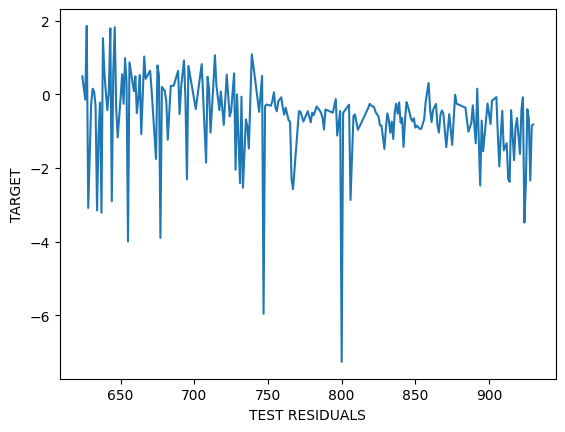

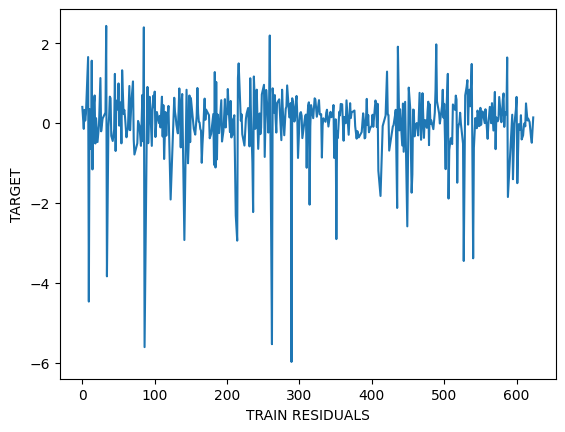

In [61]:
ridge = linear_model.Ridge(alpha=5)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=True)

#### XGB Regression

fit on test set: 33.9%
fit on training set: 37.1%



<Figure size 640x480 with 0 Axes>

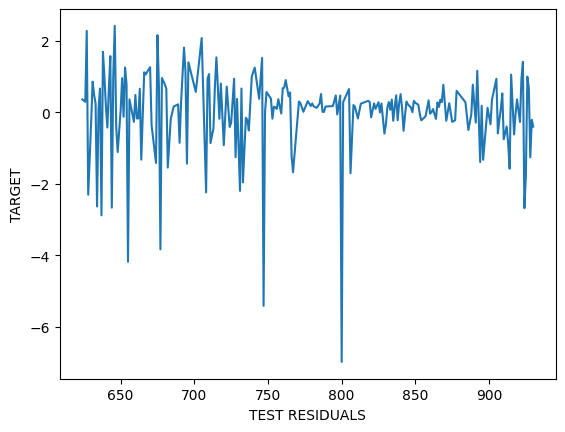

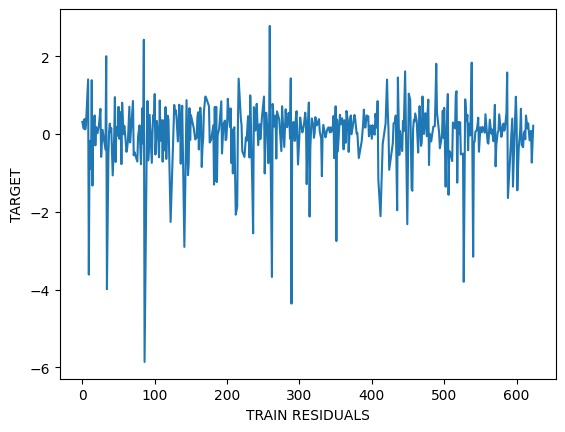

In [68]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=True)

In [69]:
kf_test_model(kf, xgb_model, x, target)

fit on test set: 3.2%
fit on training set: 42.0%

fit on test set: 38.9%
fit on training set: 40.1%

fit on test set: 29.1%
fit on training set: 40.2%

fit on test set: 32.4%
fit on training set: 41.3%

fit on test set: 44.7%
fit on training set: 41.5%

fit on test set: 18.8%
fit on training set: 40.8%

fit on test set: 49.7%
fit on training set: 39.1%

fit on test set: 32.5%
fit on training set: 44.1%

fit on test set: 50.4%
fit on training set: 39.2%

fit on test set: 22.9%
fit on training set: 40.0%



#### Ridge Regression - XGB Hybrid

model_0 fit on test set: 33.7%
model_0 fit on train set: 42.6%
model_1 fit on test residuals: 9.7%
model_1 fit on train residuals: 15.6%
fit on test set: 34.4%
fit on training set: 38.0%



<Figure size 640x480 with 0 Axes>

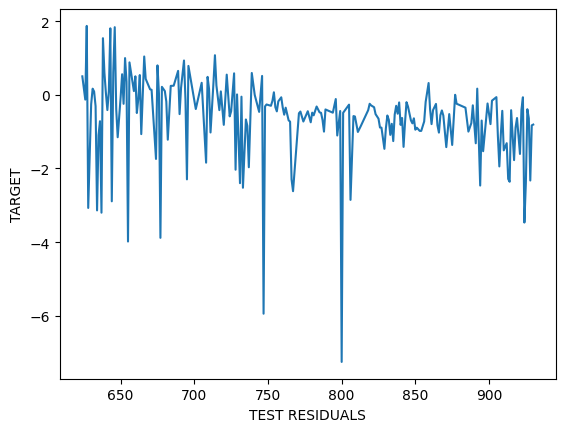

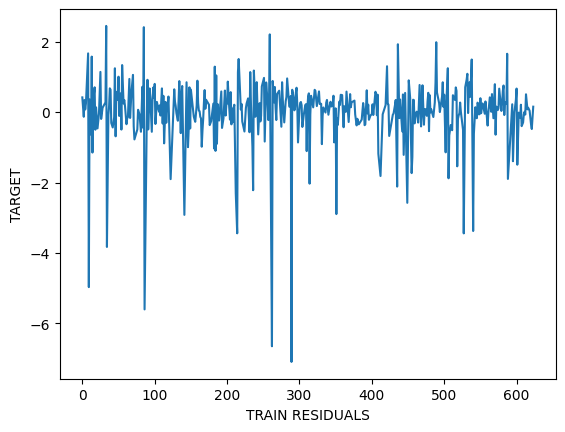

In [70]:
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

#### MLP Regressor

In [65]:
mlpr = MLPRegressor(alpha=0.001, solver='lbfgs', hidden_layer_sizes=(50, 20))
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test)

fit on test set: 31.1%
fit on training set: 33.2%



### Submission

Make sure to change x_train and x_test to be the proper sets

In [66]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, eta=0.3, gamma=15, max_depth=5)
xgb_model.fit(x_train, y_train)

y_test_submission = true_test.copy()
y_test_submission['TARGET'] = xgb_model.predict(x_test)

y_test_submission['TARGET'].to_csv('andrew_qrt_submission.csv', index=False)

ValueError: Length of values (213) does not match length of index (654)